Assignment 1:  Multivariate Linear Regression using Gradient Descent Algorithm \
Submitted by Group 5 \

Groupmembers:

1. Sajan Kumer Sarker (2111131642) (sajan.sarker@northsouth.edu)
2. Rafsan Jani Chowdhury (2011424642) (rafsan.chowdhury@northsouth.edu)
3. Rosely Mohammad (2014219642) (rosely.mohammad@northsouth.edu)

Task: Perform Multivariate linear regression using gradient descent on the Air Quality dataset and report Mean Squared Error (MSE) for training and testing dataset.

In [ ]:
import numpy as np
import pandas as pd
import math, copy
import matplotlib.pyplot as plt

In [ ]:
# Set Pandas options to display all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap to new line
pd.set_option('display.max_colwidth', None)  # No column width limit

Install the ucimlrepo package

In [ ]:
# pip install ucimlrepo

*****
# Import the dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
air_quality_data = air_quality.data.features

print(air_quality_data)

           Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH
0     3/10/2004  18:00:00     2.6         1360       150      11.9           1046      166          1056      113          1692         1268  13.6  48.9  0.7578
1     3/10/2004  19:00:00     2.0         1292       112       9.4            955      103          1174       92          1559          972  13.3  47.7  0.7255
2     3/10/2004  20:00:00     2.2         1402        88       9.0            939      131          1140      114          1555         1074  11.9  54.0  0.7502
3     3/10/2004  21:00:00     2.2         1376        80       9.2            948      172          1092      122          1584         1203  11.0  60.0  0.7867
4     3/10/2004  22:00:00     1.6         1272        51       6.5            836      131          1205      116          1490         1110  11.2  59.6  0.7888
...         ...       ...     ... 

*****
# Dataset Pre-processing Functions

finding missing values, replaces missing values, z score normalization

In [ ]:
# Missing values are tagged with -200 value.
def find_missing_values(data):
  for column in data.columns:
    count = 0
    count = (data[column] == -200).sum()
    print(f"{column:13} has {count:5} occurrences.")

In [ ]:
# replacing -200 with mean of each features.
def replace_with_mean(data):
  for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
      mean_value = data[data[column] != -200][column].mean()
      data[column] = data[column].replace(-200, mean_value)
      # print(f"Mean of {column:13} is: {mean_value:8.4f}")
  return pd.DataFrame(data)

In [ ]:
# Feature remove function
def remove_feature(X, features_names):
  return X.drop(columns=features_names)

In [ ]:
# Mean Normalization functions for training and test dataset
tr_mean = []  # global mean
tr_std = []   # global standard deviation

def zscore_normalize_train(X):    # normalize train data only
  m, n = X.shape
  norm_X = []

  for col in range(n):
    col_values = X.iloc[:, col]
    mean = sum(col_values) / m
    tr_mean.append(mean)

    sum_sq_diff = sum((val - mean)**2 for val in col_values)
    std = (sum_sq_diff / m)**0.5
    tr_std.append(std)

    norm_col = [(val - mean) / std for val in col_values]
    norm_X.append(norm_col)

  norm_X = [list(row) for row in zip(*norm_X)]
  norm_X = pd.DataFrame(norm_X, columns=X.columns)
  return norm_X

def zscore_normalize_test(X):    # normalize test data only
  m, n = X.shape
  norm_X = []

  for col in range(n):
    col_values = X.iloc[:, col]

    norm_col = [(val - tr_mean[col]) / tr_std[col] for val in col_values]
    norm_X.append(norm_col)

  norm_X = [list(row) for row in zip(*norm_X)]
  norm_X = pd.DataFrame(norm_X, columns=X.columns)
  return norm_X

*****
# Data Pre-processing

In [ ]:
# getting more info about the data
print(air_quality_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB
None


In [ ]:
# Checking for missing Values
print(find_missing_values(air_quality_data))

Date          has     0 occurrences.
Time          has     0 occurrences.
CO(GT)        has  1683 occurrences.
PT08.S1(CO)   has   366 occurrences.
NMHC(GT)      has  8443 occurrences.
C6H6(GT)      has   366 occurrences.
PT08.S2(NMHC) has   366 occurrences.
NOx(GT)       has  1639 occurrences.
PT08.S3(NOx)  has   366 occurrences.
NO2(GT)       has  1642 occurrences.
PT08.S4(NO2)  has   366 occurrences.
PT08.S5(O3)   has   366 occurrences.
T             has   366 occurrences.
RH            has   366 occurrences.
AH            has   366 occurrences.
None


In [ ]:
# Delete the date and time columns, and those columns with more than 1,000 missing values
feature_name = ['Date', 'Time', 'CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']
air_quality_data = remove_feature(air_quality_data, feature_name)

# replace the missing values with mean of remaining columns
air_quality_data = replace_with_mean(air_quality_data)
print(air_quality_data.head())

   PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH
0       1360.0      11.9         1046.0        1056.0        1692.0       1268.0  13.6  48.9  0.7578
1       1292.0       9.4          955.0        1174.0        1559.0        972.0  13.3  47.7  0.7255
2       1402.0       9.0          939.0        1140.0        1555.0       1074.0  11.9  54.0  0.7502
3       1376.0       9.2          948.0        1092.0        1584.0       1203.0  11.0  60.0  0.7867
4       1272.0       6.5          836.0        1205.0        1490.0       1110.0  11.2  59.6  0.7888


**Now Spliting the dataset 75% for for training data and 25% for test data**

In [ ]:
# find index number of 75% data
train_data_index = int(len(air_quality_data) * 0.75)

train = air_quality_data[:train_data_index] # train data
test = air_quality_data[train_data_index:]  # test data

train_data = zscore_normalize_train(train)  # normalize train data
test_data = zscore_normalize_test(test)     # normalize test data


train_data.to_csv('./AirQualityTrainingData.csv', index=False)
test_data.to_csv('./AirQualityTestData.csv', index=False)

print(f"Shape of Whole Dataset: {air_quality_data.shape}")
print(f"Shape of Training Dataset: {train_data.shape}")
print(f"Shape of Test Dataset: {test_data.shape}")

Shape of Whole Dataset: (9357, 9)
Shape of Training Dataset: (7017, 9)
Shape of Test Dataset: (2340, 9)


In [ ]:
train_data = pd.read_csv('./AirQualityTrainingData.csv').to_numpy()
test_data = pd.read_csv('./AirQualityTestData.csv').to_numpy()

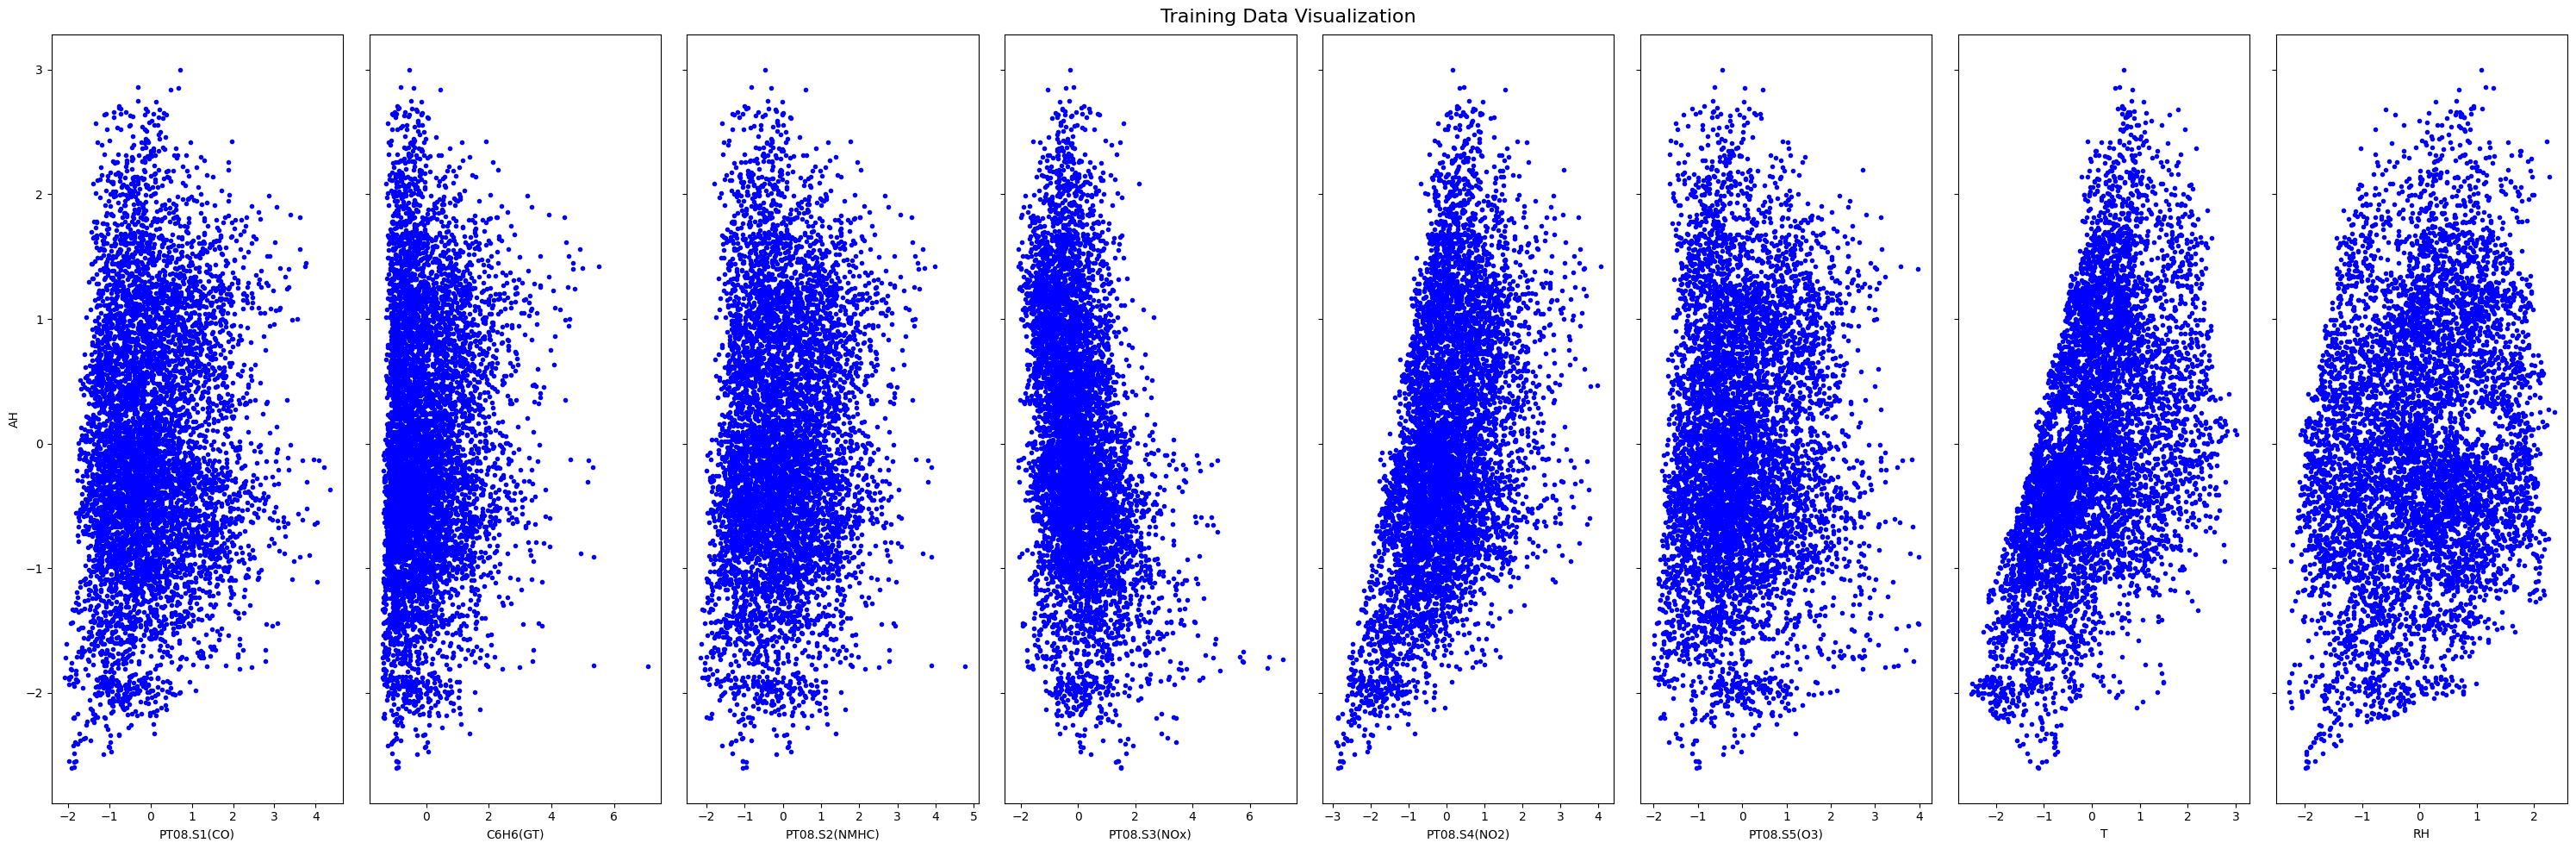

In [ ]:
# Split features and target for train and test dataset
X_train = train_data[:, :8]
y_train = train_data[:, 8]
X_test = test_data[:, :8]
y_test = test_data[:, 8]

# visualize the train data
X_features = ['PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)','T','RH']

fig, ax = plt.subplots(1, 8, figsize=(30, 10), sharey=True)
fig.suptitle("Training Data Visualization", fontsize=16)

for i in range(0, 8):
  ax[i].scatter(X_train[:, i], y_train, marker='.', c='b')
  ax[i].set_xlabel(X_features[i])

ax[0].set_ylabel('AH')
plt.tight_layout()
plt.show()

*****
# Linear Regression Algorithm Functions

In [ ]:
# cost function
def compute_cost(X, y, w, b):
  m = X.shape[0]
  cost = 0.0

  for i in range(m):
    f_wb_i = np.dot(X[i], w) + b
    cost = cost + (f_wb_i - y[i])**2

  cost = cost / (2*m)
  return cost

In [ ]:
# compute the gradient for linear regression
def compute_gradient(X, y, w, b):
  m, n = X.shape
  dj_dw = np.zeros((n,))
  dj_db = 0

  for i in range(m):
    err = (np.dot(X[i], w) + b) - y[i]

    for j in range(n):
      dj_dw[j] = dj_dw[j] + err * X[i, j]
    dj_db = dj_db + err

  dj_dw = dj_dw / m
  dj_db = dj_db / m

  return dj_db, dj_dw

In [ ]:
# gradient descent algorithm
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
  J_history = []  # store cost J and w's at each iteration for ploting graph.
  w = copy.deepcopy(w_in) # avoid modifying global w within function.
  b = b_in

  for i in range(num_iters):
    dj_db, dj_dw = gradient_function(X, y, w, b)

    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    if i < 100000:
      J_history.append(cost_function(X, y, w, b))   # save cost J at each iterations

    if i %math.ceil(num_iters / 10) == 0:
      print(f'Iteration {i:4d}: cost{J_history[-1]:8.2f}')

  return w, b, J_history # return final w, b and J history for ploting

In [ ]:
# mse calculation
def mse(y_actual, y_pred):
    error = 0.0

    for actual, predicted in zip(y_actual, y_pred):
        error += (actual - predicted) ** 2
    mse = error / len(y_actual)
    return mse

*****
# Running Linear Regression Gradient Descent Algorithm

In [ ]:
initial_w = np.zeros(8)
initial_b = 0
iterations = 1000
alpha = 3.0e-2

# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)

print(f"b, w found by gradient descent: {b_final:0.2f}, {w_final}")

Iteration    0: cost    0.48
Iteration  100: cost    0.09
Iteration  200: cost    0.07
Iteration  300: cost    0.06
Iteration  400: cost    0.06
Iteration  500: cost    0.06
Iteration  600: cost    0.06
Iteration  700: cost    0.06
Iteration  800: cost    0.06
Iteration  900: cost    0.06
b, w found by gradient descent: 0.00, [-0.11208505 -0.01390297 -0.3601864  -0.19865511  0.30029509  0.0988912
  1.02693376  0.88648423]


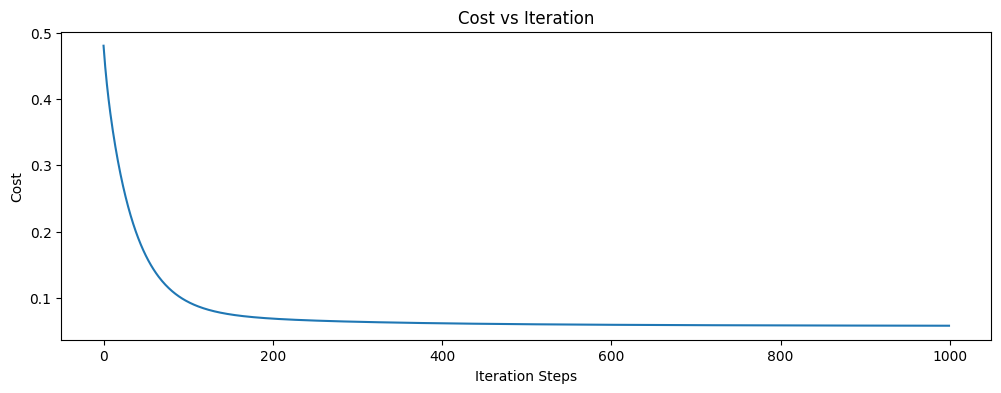

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(J_hist[:iterations])
plt.title("Cost vs Iteration")
plt.ylabel("Cost")
plt.xlabel("Iteration Steps")
plt.show()

In [ ]:
# train set predictions
y_train_predict = np.dot(X_train, w_final) + b_final

print(f"MSE for Training Set: {mse(y_train, y_train_predict)}")

MSE for Training Set: 0.11557484573819819


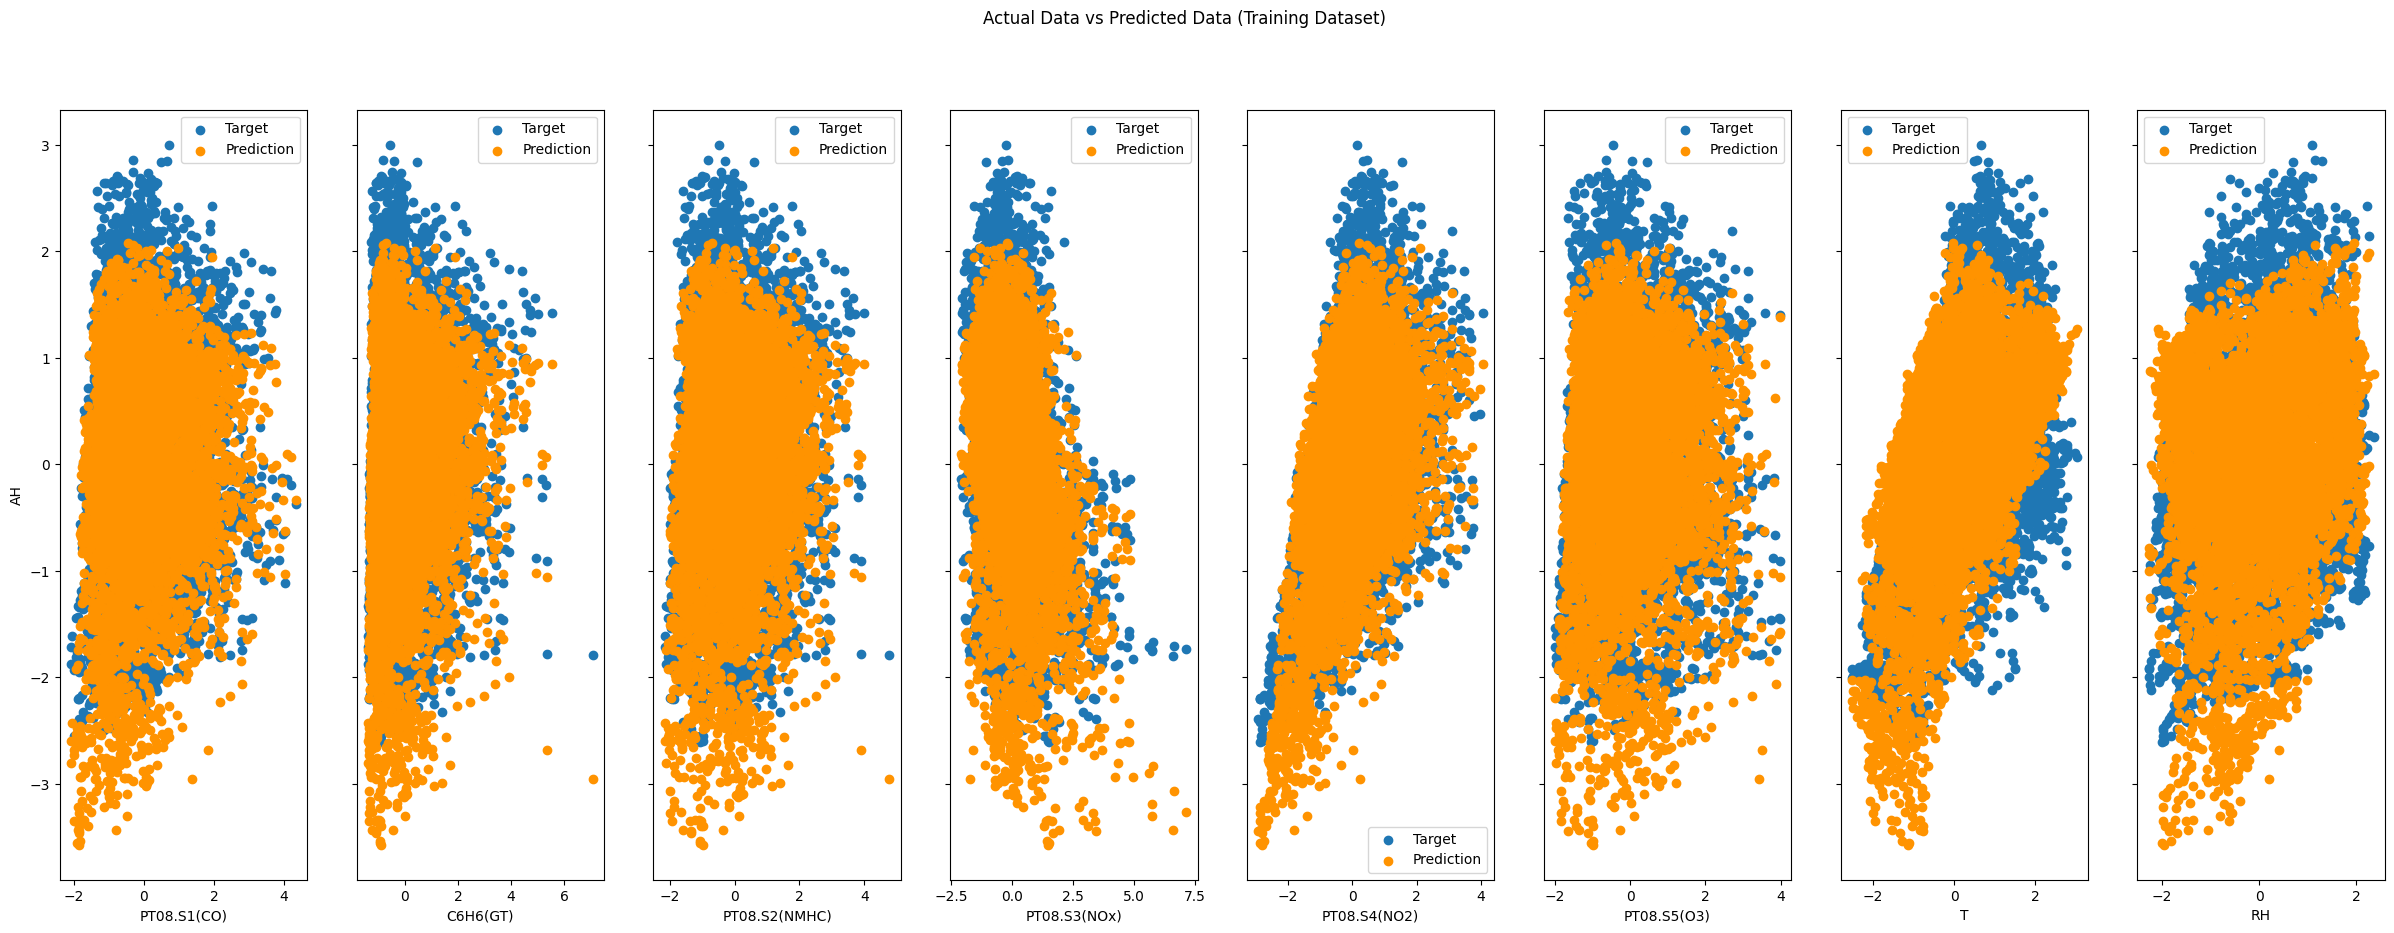

In [ ]:
# ploting actual training data vs predicted training data
X_features = ['PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)','T','RH']

fig, ax = plt.subplots(1, 8, figsize=(30, 10), sharey=True)
fig.suptitle("Actual Data vs Predicted Data (Training Dataset)")

for i in range(8):
  ax[i].scatter(X_train[:,i], y_train, label='Target')
  ax[i].scatter(X_train[:,i], y_train_predict, color='#FF9300', label="Prediction")
  ax[i].set_xlabel(X_features[i])
  ax[i].legend()

ax[0].set_ylabel('AH')
plt.show()

In [ ]:
# test set predictions
y_test_predict = np.dot(X_test, w_final) + b_final

print(f"MSE for Training Set: {mse(y_test, y_test_predict)}")

MSE for Training Set: 0.19075763020496814


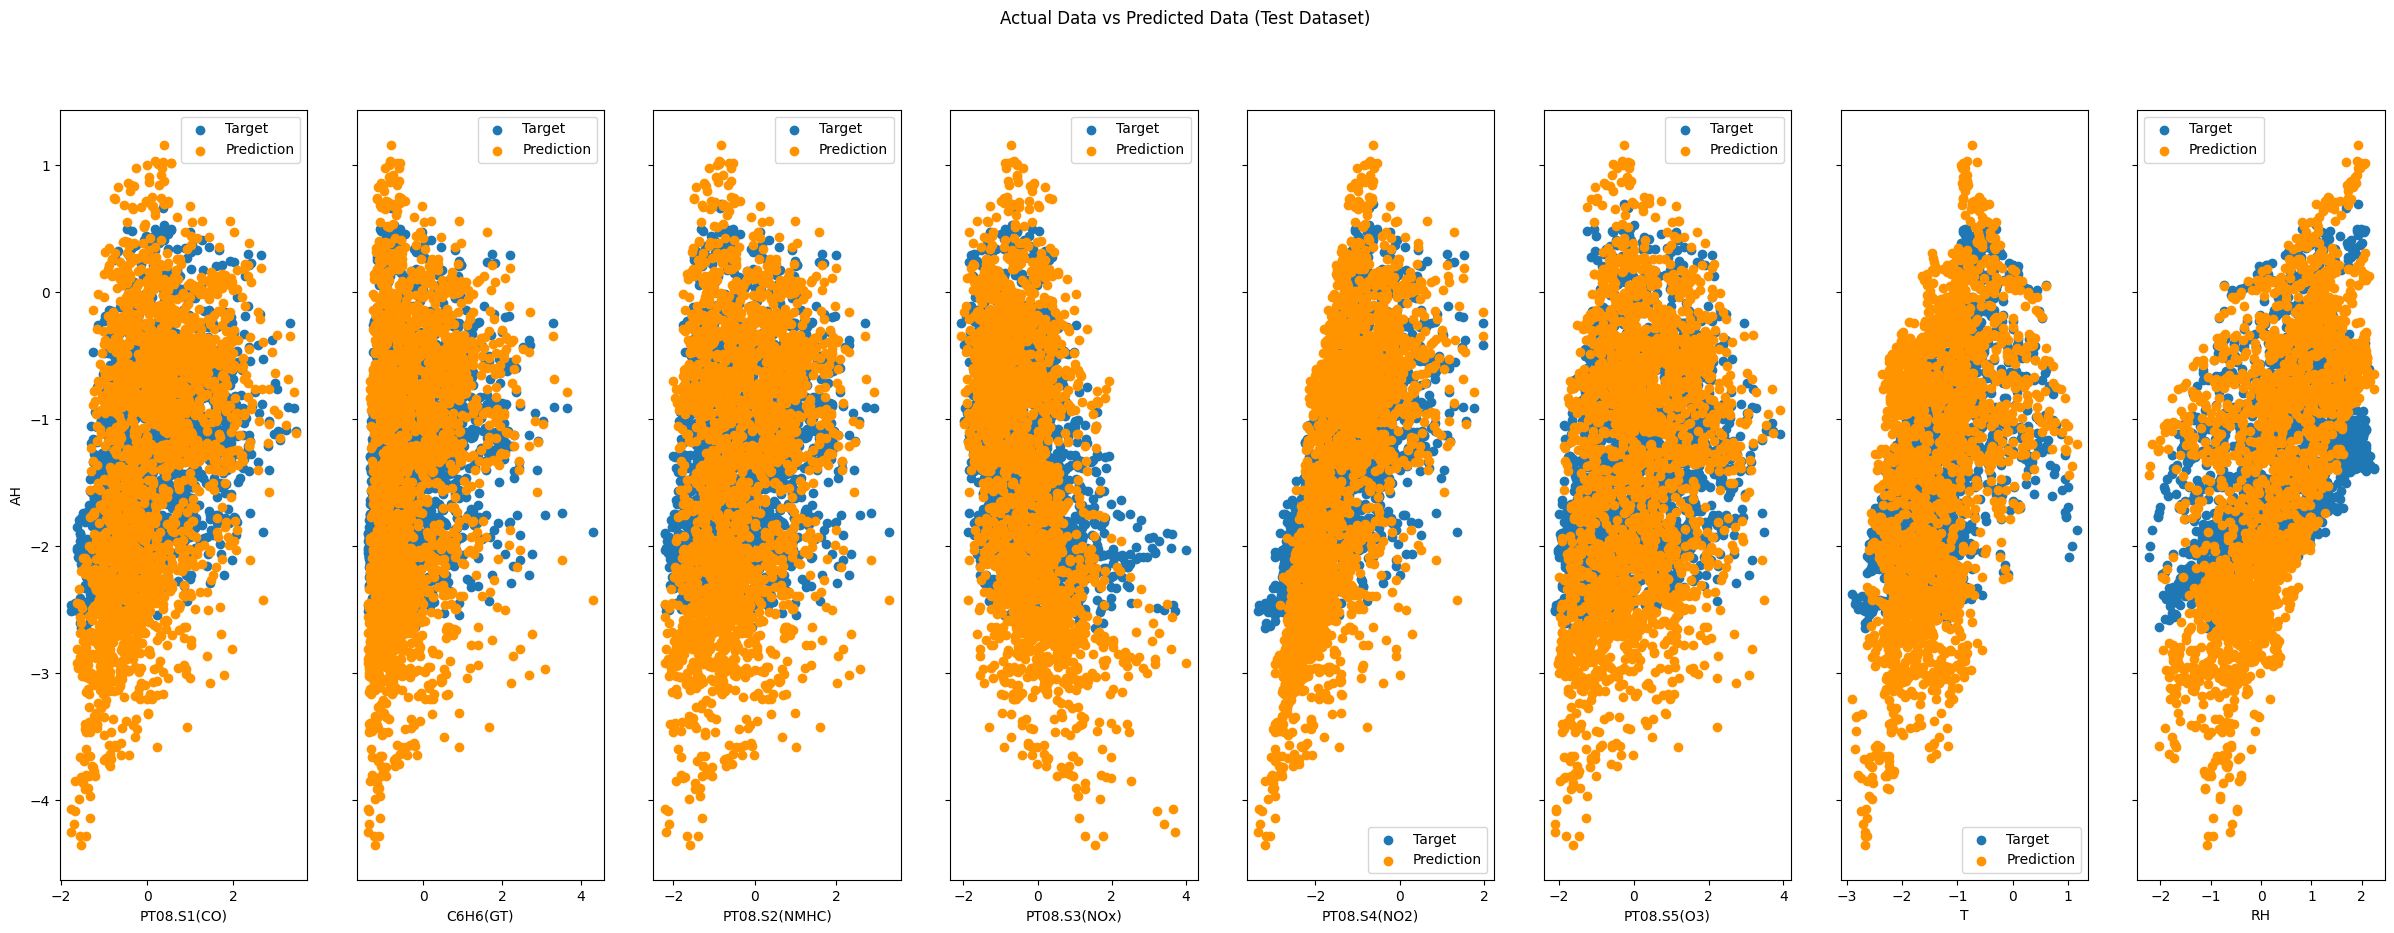

In [ ]:
# ploting actual test data vs predicted test data
X_features = ['PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)','T','RH']

fig, ax = plt.subplots(1, 8, figsize=(30, 10), sharey=True)
fig.suptitle("Actual Data vs Predicted Data (Test Dataset)")

for i in range(8):
  ax[i].scatter(X_test[:,i], y_test, label='Target')
  ax[i].scatter(X_test[:,i], y_test_predict, color='#FF9300', label="Prediction")
  ax[i].set_xlabel(X_features[i])
  ax[i].legend()

ax[0].set_ylabel('AH')
plt.show()